In [248]:
import numpy as np
from mizani.transforms import trans, trans_new
from mizani import breaks, formatters
import pandas as pd
import plotnine as p
from scipy import stats
from scvi.hub import HubMetadata, HubModel, HubModelCardHelper

class neg_log10(trans):
    @staticmethod
    def transform(x):
        return -np.log10(x)

    @staticmethod
    def inverse(x):
        return 10 ** -x
    
    
class trans_log10(trans):
    @staticmethod
    def transform(x):
        return np.log10(x)

    @staticmethod
    def inverse(x):
        return 10 ** x

    
class neg_log10_breaks:
    def __init__(self, n = 5):
        self.n = n

    def __call__(self, limits):
        _min = int(np.floor(np.log10(limits[1])))
        breaks = np.array([[10. ** k, 5. * 10. ** (k - 1)] for k in range(0, _min, -1)]).ravel()

        return breaks.tolist()

In [2]:
sheet_dict = pd.read_excel('41586_2023_6816_MOESM5_ESM.xlsx', sheet_name = None)

In [3]:
cytokine_responses = pd.concat(sheet_dict.values()).reset_index(drop = True)

In [4]:
cytokine_responses

,Celltype,Celltype_Str,Cytokine,Cytokine_Str,Gene,Avg_log2FC,FDR,Pct_Cytokine,Pct_PBS
0,B cell,B_cell,IL-1α,IL1a,Zfp36l2,1.090930,8.007951e-20,0.509,0.217
1,B cell,B_cell,IL-1α,IL1a,Arap2,0.891994,7.896447e-10,0.314,0.110
2,B cell,B_cell,IL-1α,IL1a,Socs3,0.843500,5.320295e-10,0.160,0.023
3,B cell,B_cell,IL-1α,IL1a,Napsa,0.808776,1.244916e-14,0.794,0.585
4,B cell,B_cell,IL-1α,IL1a,Gpr171,0.791013,1.743135e-09,0.331,0.124
...,...,...,...,...,...,...,...,...,...
71982,Treg,Treg,Noggin,Noggin,Dusp1,-1.393710,1.635109e-07,0.158,0.392
71983,Treg,Treg,TPO,TPO,Rgs2,-0.801164,3.999226e-02,0.117,0.235
71984,Treg,Treg,TPO,TPO,Junb,-0.817614,4.794422e-03,0.531,0.643
71985,Treg,Treg,TPO,TPO,Fos,-0.862637,1.773044e-02,0.079,0.207


In [12]:
cytokine_responses.groupby(['Celltype_Str']).size()

Celltype_Str
B_cell         3644
ILC             390
Langerhans     1819
Macrophage     3044
Mast_cell       564
MigDC          3736
Monocyte       3609
NK_cell        8205
Neutrophil      484
T_cell_CD4     4253
T_cell_CD8     6231
T_cell_gd      7505
Treg           3506
cDC1           8058
cDC2          13062
eTAC            108
pDC            3769
dtype: int64

In [7]:
hmo = HubModel.pull_from_huggingface_hub(
    repo_name = 'valsv/mmColon_single_cell_85K.mouse.scvi.model',
)

/tmp/ipykernel_14737/3266896373.py:1: UserWarning: No revision was passed, so the default (latest) revision will be used.
  hmo = HubModel.pull_from_huggingface_hub(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

_scvi_required_metadata.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

adata.h5ad:   0%|          | 0.00/129M [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.39k [00:00<?, ?B/s]

In [9]:
vae = hmo.model

In [10]:
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: True

In [15]:
vae.adata.obs.groupby(['celltype_minor', 'condition'], observed = True).size()

celltype_minor      condition     
B cell              AcuteColitis       4038
                    ChronicColitis    14264
                    Healthy            7784
Dendritic cell      AcuteColitis        384
                    ChronicColitis      767
                    Healthy             153
Endothelial cell    AcuteColitis       2806
                    ChronicColitis     3732
                    Healthy            2534
Epithelial cell     AcuteColitis        192
                    ChronicColitis      715
                    Healthy            3558
Fibroblast          AcuteColitis       4961
                    ChronicColitis     4697
                    Healthy            6442
ILC                 AcuteColitis       1001
                    ChronicColitis     1348
                    Healthy            1316
Macrophage          AcuteColitis       1269
                    ChronicColitis     3733
                    Healthy             591
Monocyte            AcuteColitis         

In [273]:
idx_ = (
    vae.adata.obs
    .query('celltype_minor == "Macrophage"')
    .query('condition in ["Healthy", "AcuteColitis"]')
    .index
)
tmp_ = vae.adata[idx_].copy()

de_results = vae.differential_expression(
    tmp_,
    groupby = 'condition',
    group1 = 'AcuteColitis',
    group2 = 'Healthy'
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


/home/vale/mambaforge/lib/python3.10/site-packages/scvi/model/_utils.py:257: RuntimeWarning: divide by zero encountered in divide


In [274]:
celltype_response = cytokine_responses.query('Celltype_Str == "Macrophage"').copy()
celltype_response['Gene'] = celltype_response['Gene'].map(lambda s: [s])
response_sets = celltype_response.groupby(['Cytokine'])['Gene'].sum().to_dict()

In [291]:
fde_r = (
    de_results
    .query('proba_de > 0.95')
    .sort_values('lfc_median', ascending = False)
)

de_genes = set(fde_r.index)
universe = set(vae.adata.var.index)

results = pd.DataFrame(
    1,
    index = list(response_sets.keys()),
    columns=['intersection', 'response_gene_set', 'de_genes', 'universe', 'pvals']
)
results['de_genes'] = len(de_genes)
results['universe'] = len(universe)

for ind in results.index:
    response_gene_set = set(response_sets[ind])
    common = response_gene_set.intersection(de_genes)
    results.loc[ind, "intersection"] = len(common)
    results.loc[ind, "response_gene_set"] = len(response_gene_set)
    pval = stats.hypergeom.sf(len(common) - 1, len(universe), len(de_genes), len(response_gene_set))
    results.loc[ind, 'pvals'] = pval

results['Cytokine'] = results.index

In [311]:
results.sort_values('pvals', ascending = True).head(20)

,intersection,response_gene_set,de_genes,universe,pvals,Cytokine
IL-21,1,1,96,18416,0.005213,IL-21
RANKL,1,1,96,18416,0.005213,RANKL
IL-13,2,34,96,18416,0.013536,IL-13
IL-17F,1,3,96,18416,0.015558,IL-17F
OSM,1,7,96,18416,0.035930,OSM
IL-5,1,13,96,18416,0.065708,IL-5
IL-10,1,14,96,18416,0.070582,IL-10
IL-33,1,24,96,18416,0.117957,IL-33
CT-1,1,27,96,18416,0.131698,CT-1
IL-12,1,28,96,18416,0.136231,IL-12


In [304]:
adjust_text_dict = {
    'expand_points': (2, 2),
    'arrowprops': {
        'arrowstyle': '->',
        'color': 'k'
    }
}

/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 4 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig1.png
/home/vale/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/home/vale/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


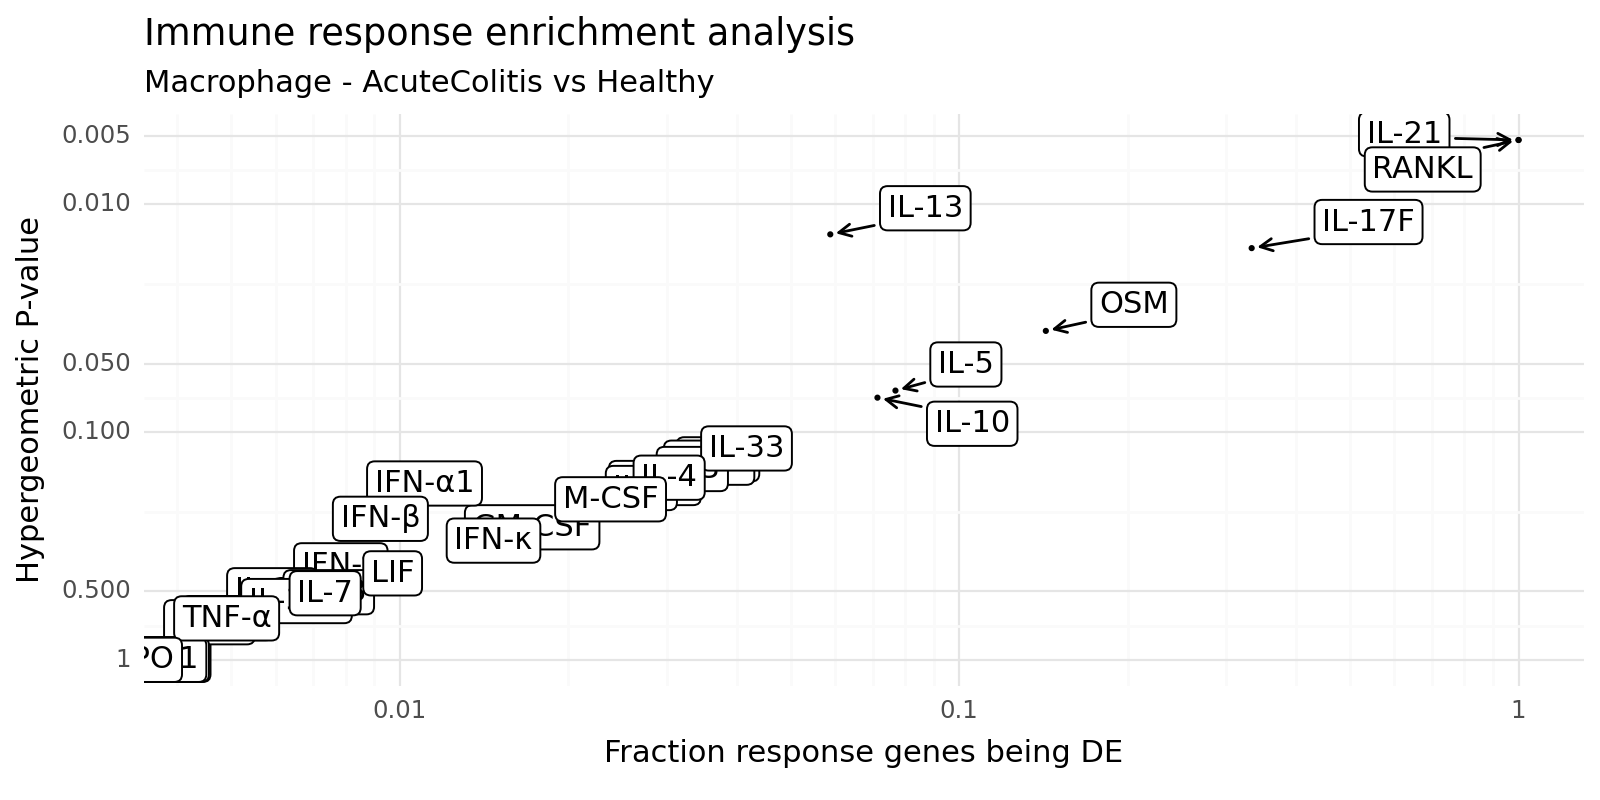

In [310]:
p.options.figure_size = 8, 4
adjust_thr = 0.1

p_ = (
    p.ggplot(p.aes(x = '(intersection / response_gene_set)', y = 'pvals'), results)
    + p.geom_point(shape = '.', size = 1.0)
    + p.geom_label(p.aes(label = 'Cytokine'), adjust_text = adjust_text_dict, data = results.query('pvals < @adjust_thr'))
    + p.geom_label(p.aes(label = 'Cytokine'), data = results.query('pvals >= @adjust_thr'))
    + p.scale_x_log10()
    + p.scale_y_continuous(
        trans = neg_log10,
        breaks = neg_log10_breaks()
    )
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 10}))
    + p.labs(
        title = 'Immune response enrichment analysis',
        subtitle = 'Macrophage - AcuteColitis vs Healthy',
        x = 'Fraction response genes being DE',
        y = 'Hypergeometric P-value'
    )
)

p_.save('fig1.png', dpi = 300)

print(p_)